In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package
sys.path.append("../..")

# Third party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface

2022-10-20 19:37:52.831837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 19:37:52.831857: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.metrics.report import ClassificationReport
from librep.estimators import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport

from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
from librep.transforms import UMAP
from tabulate import tabulate

# Preparing Table

Columns:
* RF (Accuracy, F1)
* SVC (Accuracy, F1)
* KNN (Accuracy, F1)
* Trustworthiness
* Continuity
* Co-k-nearest-neighbor-size

Rows:
* UMAP (2 dim)
* Generic Autoencoders
* Topological autoencoders (L=1)
* Topological autoencoders (L=100)

In [4]:
def print_table(table_info):
    tabulated = tabulate(
        table_info,
        headers='keys',
        tablefmt='fancy_grid',
        missingval='-'
    )
    print(tabulated)


table_info = {
    'Metrics': ['RF-ACC', 'RF-F1',
                'SVC-ACC', 'SVC-F1',
                'KNN-ACC', 'KNN-F1',
                'Trustworthiness',
                'Continuity',
                'Co-k-NNs'],
    'UMAP': ['-']*9,
    'Generic-AE': ['-']*9,
    'Topo-AEv2 (L=1)': ['-']*9,
    'Topo-AEv2 (L=100)': ['-']*9
}
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │ Generic-AE   │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │ -            │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │ -            │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │ -            │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │ -            │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │ -            │ -         

# Visualization helper

In [5]:
def visualize(X, Y, filtered=None, xlim=None, ylim=None):
    data_grouped = list(zip(X, Y))
    uniques = filtered
    if filtered is None:
        uniques = np.unique(Y)
    
    for uval in uniques:
        data = [pair[0] for pair in data_grouped if pair[1]==uval]
        data_x = [unit[0] for unit in data]
        data_y = [unit[1] for unit in data]
        plt.scatter(data_x, data_y, label = uval)
    # print(data)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()

In [6]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
dataset_path = Path("../../data/old-views/KuHar/resampled_view_20Hz")

In [101]:
# Kuhar dataframes
train, validation, test = PandasDatasetsIO(dataset_path).load()

In [102]:
train.head()

,Unnamed: 0,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,normalized activity code
0,0,0.001911,-0.014536,0.005845,0.003675,-0.014972,0.025607,0.000478,-0.031141,-0.014827,...,23.235,23.223,26.260,26.249,0,300,1,2100,1051,1
1,1,0.004114,-0.003186,0.000759,0.012450,-0.032074,0.007270,-0.000470,0.006980,0.021400,...,56.292,56.292,59.245,59.245,0,300,1,5700,1037,1
2,2,-0.011282,-0.002432,-0.003199,0.008152,-0.021763,0.000309,-0.004968,-0.009551,0.001497,...,27.268,27.267,30.290,30.291,0,300,1,2700,1075,1
3,3,-0.009241,-0.004666,0.021606,-0.007200,0.003091,0.001630,0.005057,-0.008149,0.013167,...,39.421,39.420,42.441,42.440,0,300,6,3900,1008,1
4,4,-0.013083,-0.005612,0.001645,0.006823,-0.004159,0.000415,0.008178,0.002637,-0.000827,...,23.703,23.703,26.656,26.656,0,300,1,2400,1038,1


In [103]:
train

,Unnamed: 0,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,normalized activity code
0,0,0.001911,-0.014536,0.005845,0.003675,-0.014972,0.025607,0.000478,-0.031141,-0.014827,...,23.235,23.223,26.260,26.249,0,300,1,2100,1051,1
1,1,0.004114,-0.003186,0.000759,0.012450,-0.032074,0.007270,-0.000470,0.006980,0.021400,...,56.292,56.292,59.245,59.245,0,300,1,5700,1037,1
2,2,-0.011282,-0.002432,-0.003199,0.008152,-0.021763,0.000309,-0.004968,-0.009551,0.001497,...,27.268,27.267,30.290,30.291,0,300,1,2700,1075,1
3,3,-0.009241,-0.004666,0.021606,-0.007200,0.003091,0.001630,0.005057,-0.008149,0.013167,...,39.421,39.420,42.441,42.440,0,300,6,3900,1008,1
4,4,-0.013083,-0.005612,0.001645,0.006823,-0.004159,0.000415,0.008178,0.002637,-0.000827,...,23.703,23.703,26.656,26.656,0,300,1,2400,1038,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3325,3325,-1.521897,-5.127366,-6.532153,-7.805943,10.992308,17.036004,-10.767749,-9.955230,-5.821859,...,9.102,9.101,12.127,12.126,17,300,2,900,1087,17
3326,3326,-1.980455,1.321672,5.392922,-3.234459,1.134713,-2.920856,0.090717,-1.113254,2.227080,...,25.198,25.197,28.219,28.220,17,300,1,1800,1090,17
3327,3327,-0.359406,-1.191011,-0.873361,-0.615347,0.933029,2.592225,-0.231447,0.818763,4.443685,...,33.363,33.362,36.387,36.386,17,300,2,3300,1090,17
3328,3328,-2.038564,1.391516,1.993335,0.860137,-0.599232,-2.793036,-1.663548,-2.873007,-0.120694,...,84.916,84.915,87.939,87.938,17,300,2,8400,1090,17


In [9]:
# Kuhar features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_dataset = PandasMultiModalDataset(
    train,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Validation
validation_dataset = PandasMultiModalDataset(
    validation,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Test
test_dataset = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

# Transforming KuHAR to 20Hzs

In [10]:
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [11]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [12]:
train_dataset_fft = transformer(train_dataset)
validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test_dataset)

In [13]:
print(train_dataset_fft.X.shape)
print(validation_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3330, 180)
(108, 180)
(378, 180)


In [14]:
print(np.max(train_dataset_fft.X))

1182.4630044066


In [15]:
train_dataset_fft.X

array([[2.08923330e-02, 1.12081089e-01, 6.03699767e-02, ...,
        6.86907330e-03, 1.25349286e-02, 1.69158661e-02],
       [1.53802877e-02, 8.24343989e-02, 4.18766153e-02, ...,
        3.72912157e-03, 3.98584265e-03, 1.71193131e-02],
       [5.21272671e-02, 4.82816195e-02, 8.93573044e-02, ...,
        9.75422945e-03, 2.66463902e-02, 7.84359780e-03],
       ...,
       [2.46594280e+00, 2.97792077e+01, 2.58438841e+01, ...,
        1.43625028e+00, 7.98405975e-01, 2.66617405e-01],
       [3.12703194e+00, 2.12859482e+01, 9.31637610e+00, ...,
        4.71804217e-01, 9.06413206e-01, 6.75740676e-01],
       [1.48890233e+01, 6.63385820e+00, 8.58902995e+00, ...,
        3.19953749e-01, 1.27100790e-01, 3.83110579e-01]])

In [16]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

# Applying Scaler

MinMaxScaler, MaxAbsScaler and StandardScaler apply the scaling PER FEATURE, which means the distance between points would actually be modified, and so, the ranking as well.
Because of this, a new Scaler is used

In [17]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [18]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = 2*(np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x))
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [19]:
# from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()

In [20]:
# train_HD = scaler.fit_transform(train_dataset_fft.X)
# train_LD = None
# # train_Y = train_dataset_fft.y
# test_HD = scaler.fit_transform(test_dataset_fft.X)
# test_LD = None
# # test_Y = test_dataset_fft.y

## Set Reporter

In [21]:
reporter = ClassificationReport(
    use_accuracy=True, 
    use_f1_score=True,
    use_classification_report=False,
    use_confusion_matrix=False,
    plot_confusion_matrix=False
)

# **SECTION:** Reducing with Generic AE

The topological autoencoder can be used as a generic one by applying a lambda value of 0.

In [22]:
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 0
topo_reducer = TopologicalDimensionalityReduction(
    ae_model='DeepAEforKuhar180ver2',
    lam = topoae_lambda,
    ae_kwargs = kwargs,
    input_shape = input_shape,
    patience=10
)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:367.2455, Loss-ae:367.2455, Loss-topo:151.3101
Epoch:2, P:10, Loss:312.3340, Loss-ae:312.3340, Loss-topo:186.5478
Epoch:3, P:10, Loss:270.9058, Loss-ae:270.9058, Loss-topo:473.5514
Epoch:4, P:10, Loss:251.8728, Loss-ae:251.8728, Loss-topo:379.9772
Epoch:5, P:10, Loss:246.6731, Loss-ae:246.6731, Loss-topo:192.7844
Epoch:6, P:10, Loss:247.8050, Loss-ae:247.8050, Loss-topo:252.0866
Epoch:7, P:9, Loss:217.4036, Loss-ae:217.4036, Loss-topo:1293.6350
Epoch:8, P:10, Loss:177.2597, Loss-ae:177.2597, Loss-topo:649.3494
Epoch:9, P:10, Loss:153.4111, Loss-ae:153.4111, Loss-topo:1926.1612
Epoch:10, P:10, Loss:150.7982, Loss-ae:150.7982, Loss-topo:788.7817
Epoch:11, P:10, Loss:151.7942, Loss-ae:151.7942, Loss-topo:1116.2940
Epoch:12, P:9, Loss:146.0572, Loss-ae:146.0572, Loss-topo:1263.1043
Epoch:13, P:10, Loss:170.2682, Loss-ae:170.2682, Loss-topo:2764.4350
Epoch:14, P:9, Loss:168.5940, Loss-ae:168.5940, Loss-topo:1752.9397
Epoch:15, P:8, Loss:162.5979, Loss-ae:162.5979, Loss-t

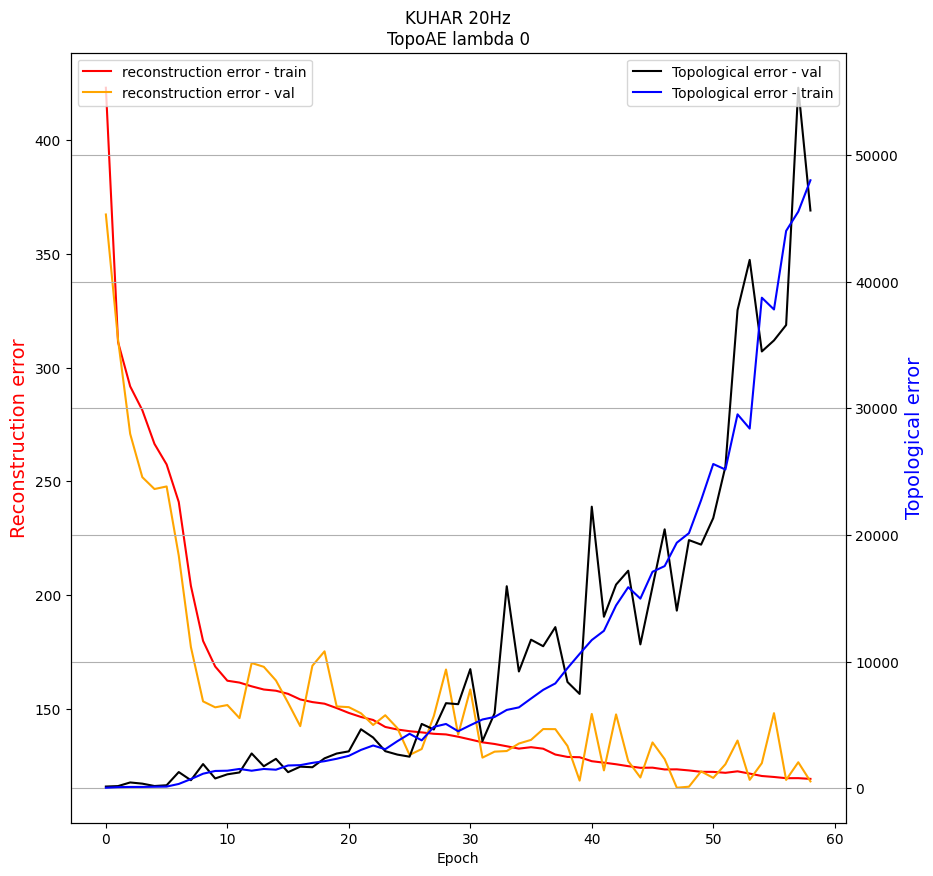

In [23]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [24]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [25]:
train_LD_pd = pd.DataFrame(train_LD)
train_LD_pd['y'] = train_Y
train_pmd = PandasMultiModalDataset(
    train_LD_pd,
    label_columns="y",
    as_array=True
)

test_LD_pd = pd.DataFrame(test_LD)
test_LD_pd['y'] = test_Y

test_pmd = PandasMultiModalDataset(
    test_LD_pd,
    label_columns="y",
    as_array=True
)

## Experiment for Random Forest

In [26]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [27]:
result = multi_run_experiment(train_pmd, test_pmd)

In [28]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.484920634920635
F1 0.49467467524476894


In [29]:
table_info['Generic-AE'][0] = accuracy
table_info['Generic-AE'][1] = f1
print_table(table_info)

╒═════════════════╤════════╤═════════════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │ Generic-AE          │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪═════════════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │ 0.484920634920635   │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │ 0.49467467524476894 │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │ -                   │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │ -                   │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼

## Experiment for SVC

In [30]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [31]:
result = multi_run_experiment(train_pmd, test_pmd)

In [32]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.3253968253968254
F1 0.38062560895430125


In [33]:
table_info['Generic-AE'][2] = accuracy
table_info['Generic-AE'][3] = f1
print_table(table_info)

╒═════════════════╤════════╤═════════════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │ Generic-AE          │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪═════════════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │ 0.484920634920635   │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │ 0.49467467524476894 │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │ 0.3253968253968254  │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │ 0.38062560895430125 │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼

## Experiment for KNN

In [34]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [35]:
result = multi_run_experiment(train_pmd, test_pmd)

In [36]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.47354497354497355
F1 0.47877013778885585


In [37]:
table_info['Generic-AE'][4] = accuracy
table_info['Generic-AE'][5] = f1
print_table(table_info)

╒═════════════════╤════════╤═════════════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │ Generic-AE          │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪═════════════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │ 0.484920634920635   │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │ 0.49467467524476894 │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │ 0.3253968253968254  │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │ 0.38062560895430125 │ -                 │ -                   │
├─────────────────┼────────┼─────────────────────┼───────────────────┼

## Obtain quality metrics

In [38]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [39]:
metrics_report

{'residual variance (pearson)': 0.1048593713175533,
 'residual variance (spearman)': 0.16620543599284276,
 'trustworthiness': 0.8627063785388362,
 'continuity': 0.9470051691073279,
 'co k nearest neighbor size': 0.3847811671087533,
 'local continuity meta criterion': 0.3422279756193916,
 'local property': 0.4993570857022654,
 'global property': 0.888046520453185}

In [40]:
table_info['Generic-AE'][6] = metrics_report['trustworthiness']
table_info['Generic-AE'][7] = metrics_report['continuity']
table_info['Generic-AE'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │ Topo-AEv2 (L=1)   │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.484921 │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.494675 │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.325397 │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.380626 │ -                 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.473545 │ -         

## Visualization

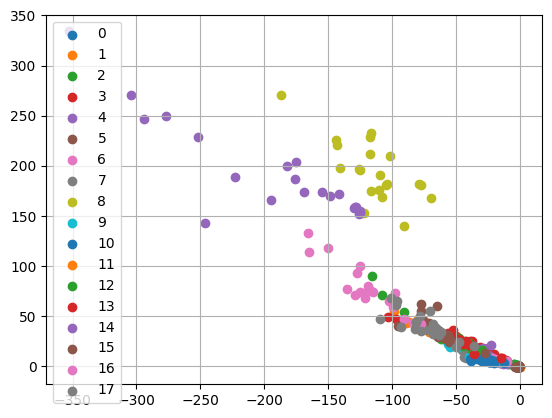

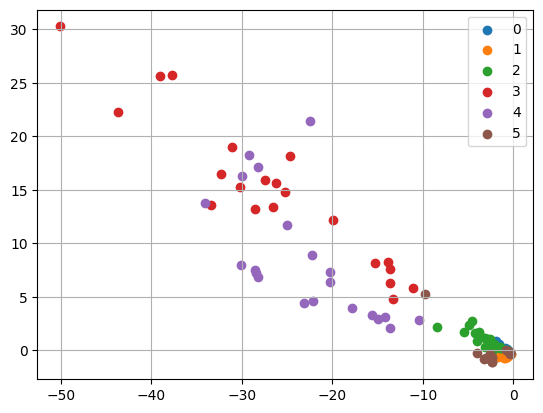

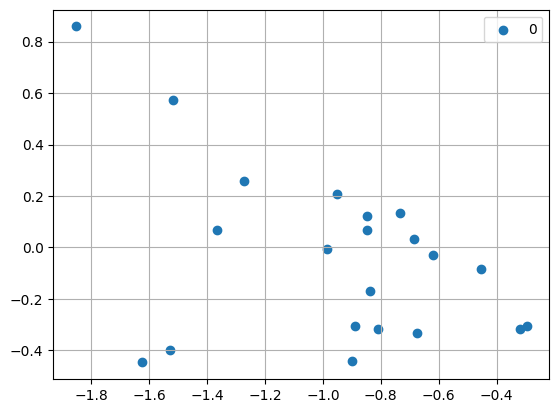

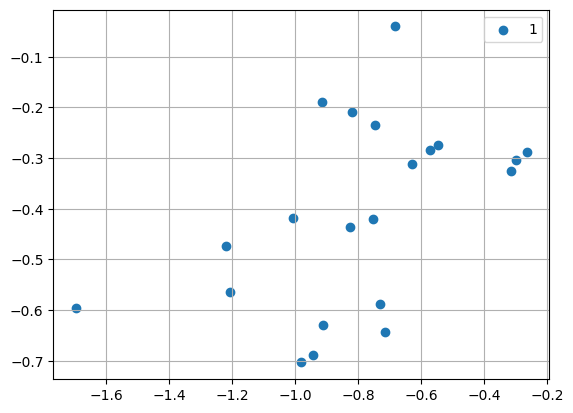

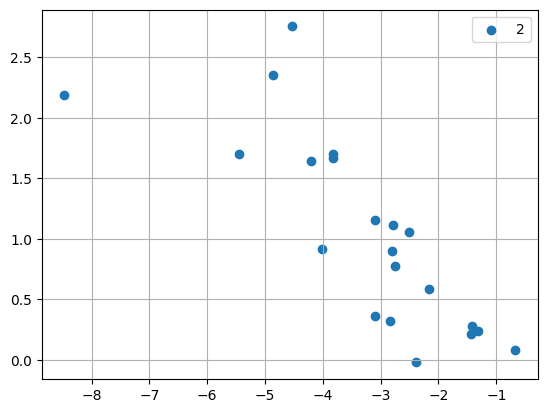

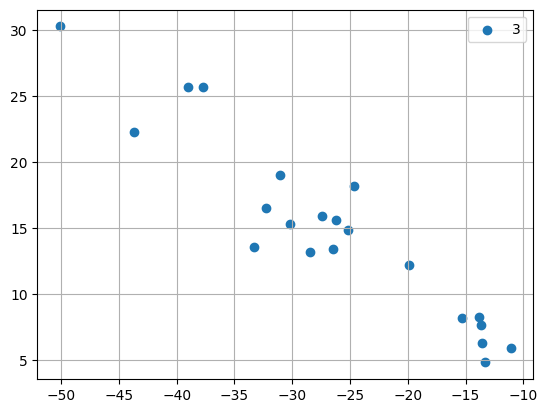

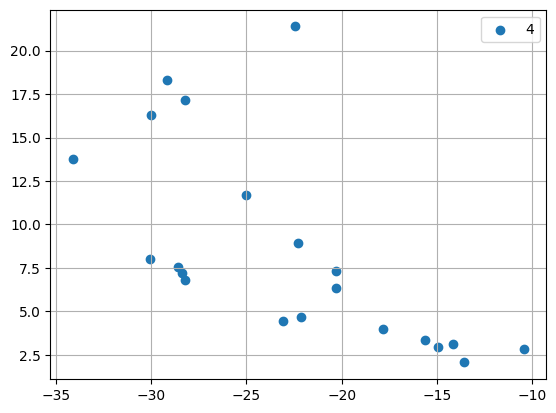

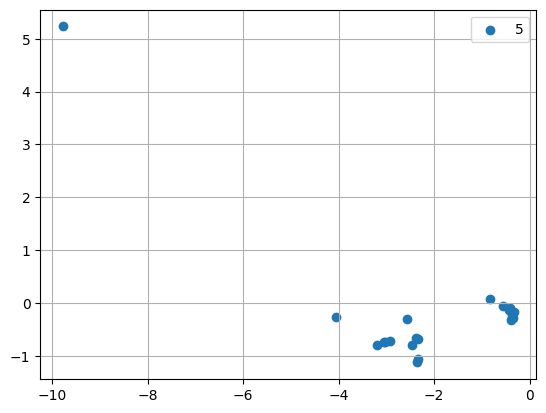

In [41]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Topological AE (lambda=1)

In [42]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 1
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:379.2727, Loss-ae:366.5263, Loss-topo:12.7464
Epoch:2, P:10, Loss:266.1458, Loss-ae:253.8331, Loss-topo:12.3126
Epoch:3, P:10, Loss:303.9776, Loss-ae:289.8425, Loss-topo:14.1351
Epoch:4, P:9, Loss:281.1406, Loss-ae:273.5568, Loss-topo:7.5838
Epoch:5, P:8, Loss:227.9312, Loss-ae:226.2275, Loss-topo:1.7036
Epoch:6, P:10, Loss:264.6293, Loss-ae:260.6505, Loss-topo:3.9788
Epoch:7, P:9, Loss:229.6755, Loss-ae:228.7154, Loss-topo:0.9601
Epoch:8, P:8, Loss:233.8989, Loss-ae:230.4778, Loss-topo:3.4211
Epoch:9, P:7, Loss:211.9965, Loss-ae:205.4860, Loss-topo:6.5105
Epoch:10, P:10, Loss:190.2726, Loss-ae:187.7341, Loss-topo:2.5385
Epoch:11, P:10, Loss:190.3033, Loss-ae:187.5470, Loss-topo:2.7563
Epoch:12, P:9, Loss:195.7251, Loss-ae:192.6619, Loss-topo:3.0633
Epoch:13, P:8, Loss:179.1683, Loss-ae:174.9945, Loss-topo:4.1739
Epoch:14, P:10, Loss:163.4216, Loss-ae:159.8814, Loss-topo:3.5402
Epoch:15, P:10, Loss:169.8407, Loss-ae:165.2051, Loss-topo:4.6356
Epoch:16, P:9, Loss:187

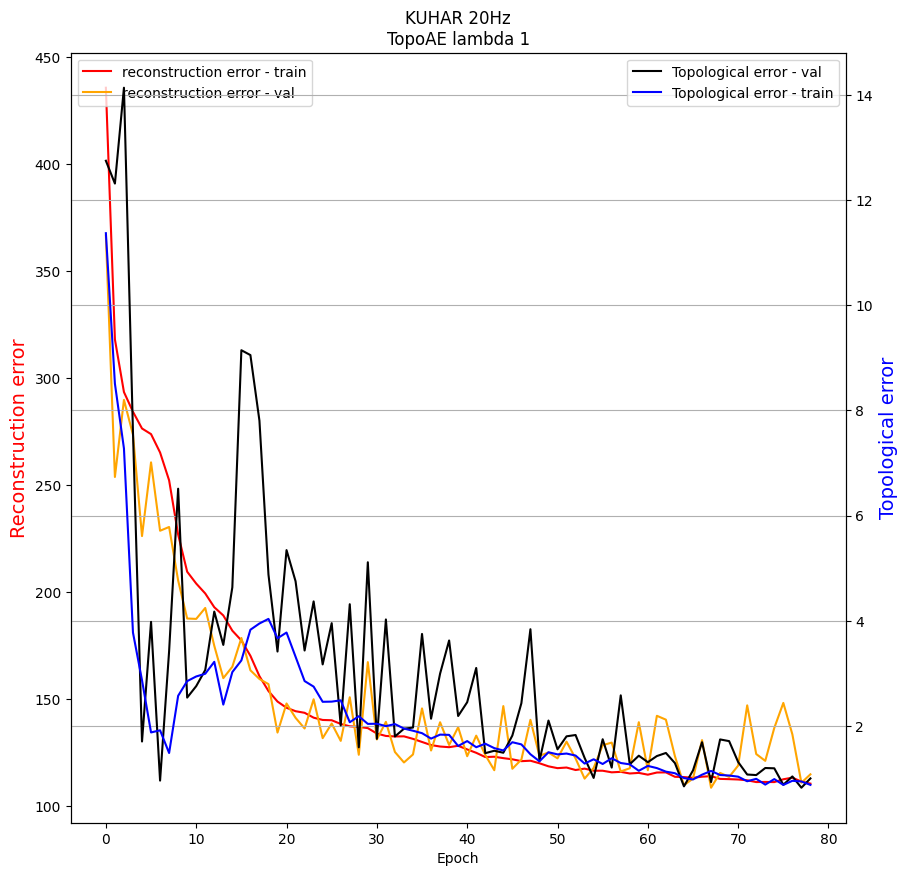

In [43]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [44]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [45]:
train_LD_pd = pd.DataFrame(train_LD)
train_LD_pd['y'] = train_Y
train_pmd = PandasMultiModalDataset(
    train_LD_pd,
    label_columns="y",
    as_array=True
)

test_LD_pd = pd.DataFrame(test_LD)
test_LD_pd['y'] = test_Y

test_pmd = PandasMultiModalDataset(
    test_LD_pd,
    label_columns="y",
    as_array=True
)

## Experiment for Random Forest

In [46]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [47]:
result = multi_run_experiment(train_pmd, test_pmd)

In [48]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.4394179894179894
F1 0.45177423703511765


In [49]:
table_info['Topo-AEv2 (L=1)'][0] = accuracy
table_info['Topo-AEv2 (L=1)'][1] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═════════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │ Topo-AEv2 (L=1)     │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═════════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.484921 │ 0.4394179894179894  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.494675 │ 0.45177423703511765 │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.325397 │ -                   │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.380626 │ -                   │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │    

## Experiment for SVC

In [50]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [51]:
result = multi_run_experiment(train_pmd, test_pmd)

In [52]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.3968253968253968
F1 0.4401166645637787


In [53]:
table_info['Topo-AEv2 (L=1)'][2] = accuracy
table_info['Topo-AEv2 (L=1)'][3] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═════════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │ Topo-AEv2 (L=1)     │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═════════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.484921 │ 0.4394179894179894  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.494675 │ 0.45177423703511765 │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.325397 │ 0.3968253968253968  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.380626 │ 0.4401166645637787  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │    

## Experiment for KNN

In [54]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [55]:
result = multi_run_experiment(train_pmd, test_pmd)

In [56]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.42328042328042326
F1 0.437594606358063


In [57]:
table_info['Topo-AEv2 (L=1)'][4] = accuracy
table_info['Topo-AEv2 (L=1)'][5] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═════════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │ Topo-AEv2 (L=1)     │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═════════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.484921 │ 0.4394179894179894  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.494675 │ 0.45177423703511765 │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.325397 │ 0.3968253968253968  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.380626 │ 0.4401166645637787  │ -                   │
├─────────────────┼────────┼──────────────┼─────────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │    

## Obtain quality metrics

In [58]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [59]:
metrics_report

{'residual variance (pearson)': 0.11058018517431001,
 'residual variance (spearman)': 0.1771936596608683,
 'trustworthiness': 0.8888288316421376,
 'continuity': 0.9501954488342873,
 'co k nearest neighbor size': 0.40019893899204245,
 'local continuity meta criterion': 0.35764574750268074,
 'local property': 0.5044626614944265,
 'global property': 0.8806809150633794}

In [60]:
table_info['Topo-AEv2 (L=1)'][6] = metrics_report['trustworthiness']
table_info['Topo-AEv2 (L=1)'][7] = metrics_report['continuity']
table_info['Topo-AEv2 (L=1)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.484921 │          0.439418 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.494675 │          0.451774 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.325397 │          0.396825 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.380626 │          0.440117 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.473545 │          0

## Visualization

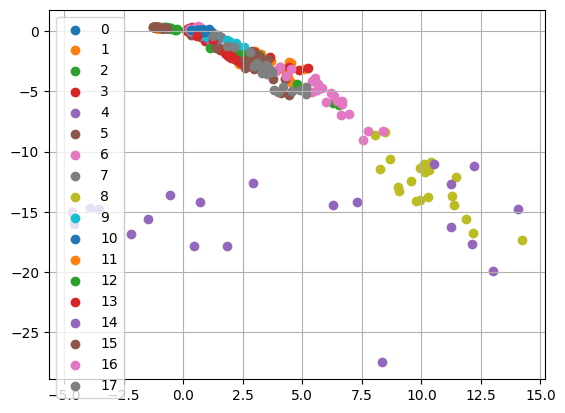

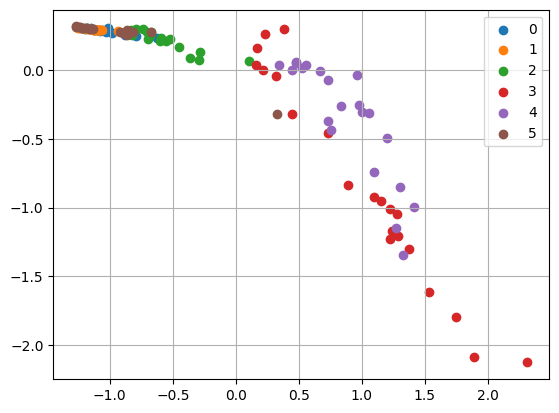

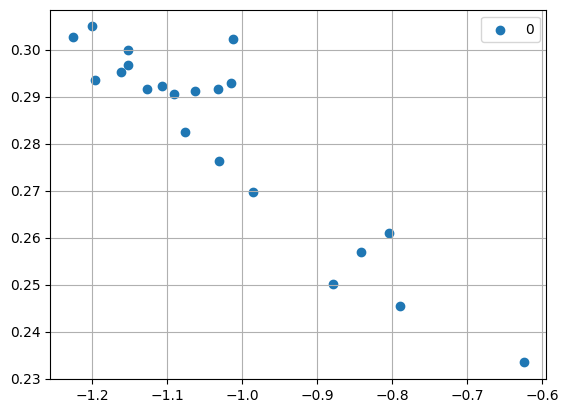

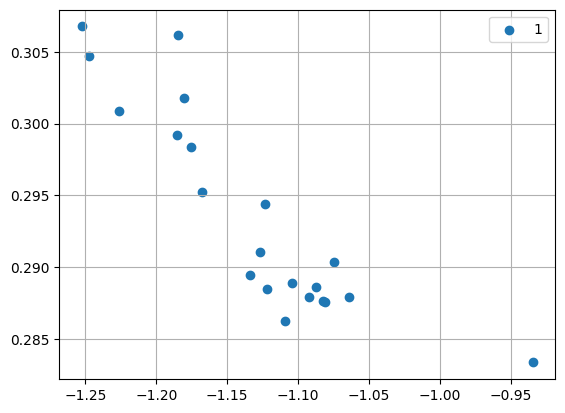

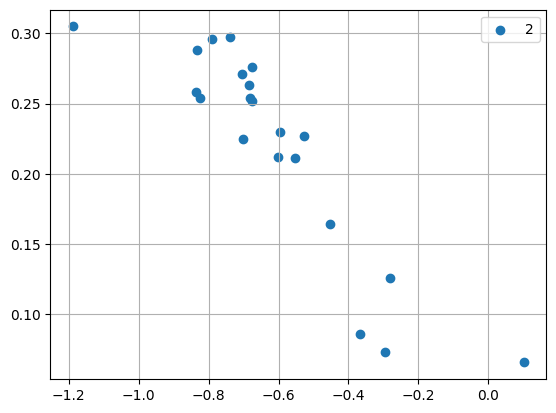

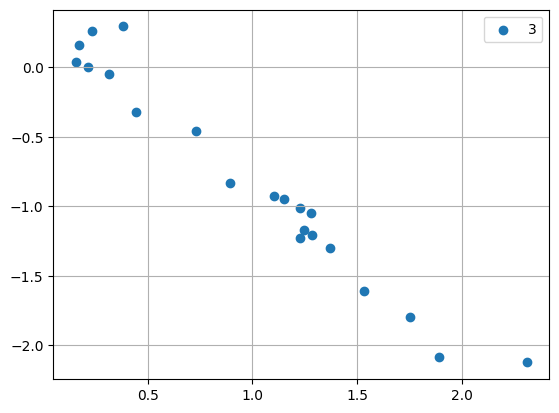

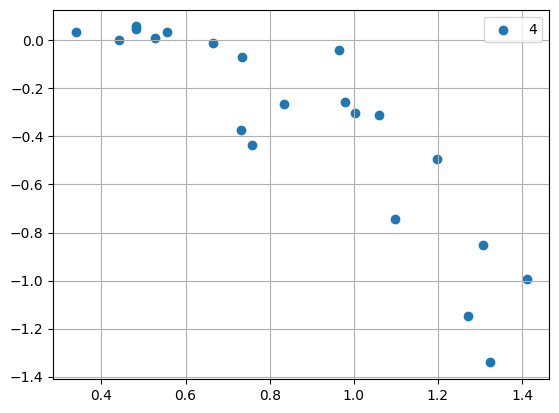

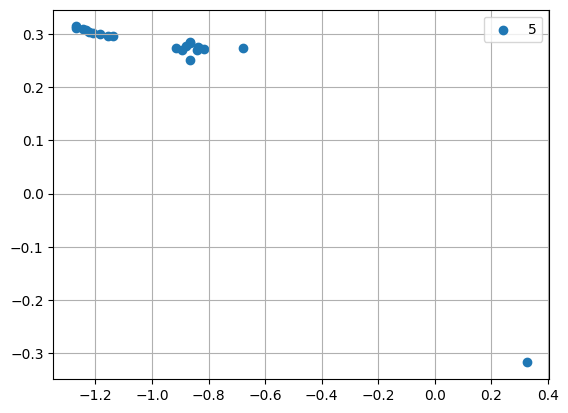

In [61]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** Topological AE (lambda=100)

In [62]:
from librep.transforms.topo_ae import TopologicalDimensionalityReduction
from librep.estimators.ae.torch.models.topological_ae.topological_ae import TopologicallyRegularizedAutoencoder
kwargs = {'input_dims':180, 'custom_dim':2}
input_shape = (-1, 1, 180)
topoae_lambda = 100
topo_reducer = TopologicalDimensionalityReduction(ae_model='DeepAEforKuhar180ver2', lam=topoae_lambda,
                                                      ae_kwargs=kwargs, input_shape=input_shape, patience=10)

Topologically Regularized DeepAEforKuhar180ver2
Using python to compute signatures
DeepAEforKuhar180ver2, Input: 180 Inner dim: 2


Epoch:1, P:10, Loss:434.2157, Loss-ae:408.2058, Loss-topo:0.2601
Epoch:2, P:10, Loss:293.1292, Loss-ae:282.6799, Loss-topo:0.1045
Epoch:3, P:10, Loss:310.5866, Loss-ae:292.9363, Loss-topo:0.1765
Epoch:4, P:9, Loss:301.2562, Loss-ae:295.3264, Loss-topo:0.0593
Epoch:5, P:8, Loss:306.8495, Loss-ae:301.4488, Loss-topo:0.0540
Epoch:6, P:7, Loss:248.2197, Loss-ae:245.4870, Loss-topo:0.0273
Epoch:7, P:10, Loss:242.3133, Loss-ae:239.9164, Loss-topo:0.0240
Epoch:8, P:10, Loss:225.4445, Loss-ae:224.3085, Loss-topo:0.0114
Epoch:9, P:10, Loss:217.3141, Loss-ae:214.8592, Loss-topo:0.0245
Epoch:10, P:10, Loss:270.2705, Loss-ae:264.2956, Loss-topo:0.0597
Epoch:11, P:9, Loss:228.6090, Loss-ae:227.4890, Loss-topo:0.0112
Epoch:12, P:8, Loss:239.4573, Loss-ae:235.6052, Loss-topo:0.0385
Epoch:13, P:7, Loss:223.8968, Loss-ae:218.3569, Loss-topo:0.0554
Epoch:14, P:6, Loss:214.8378, Loss-ae:213.6979, Loss-topo:0.0114
Epoch:15, P:10, Loss:187.4829, Loss-ae:186.2636, Loss-topo:0.0122
Epoch:16, P:10, Loss:225.3

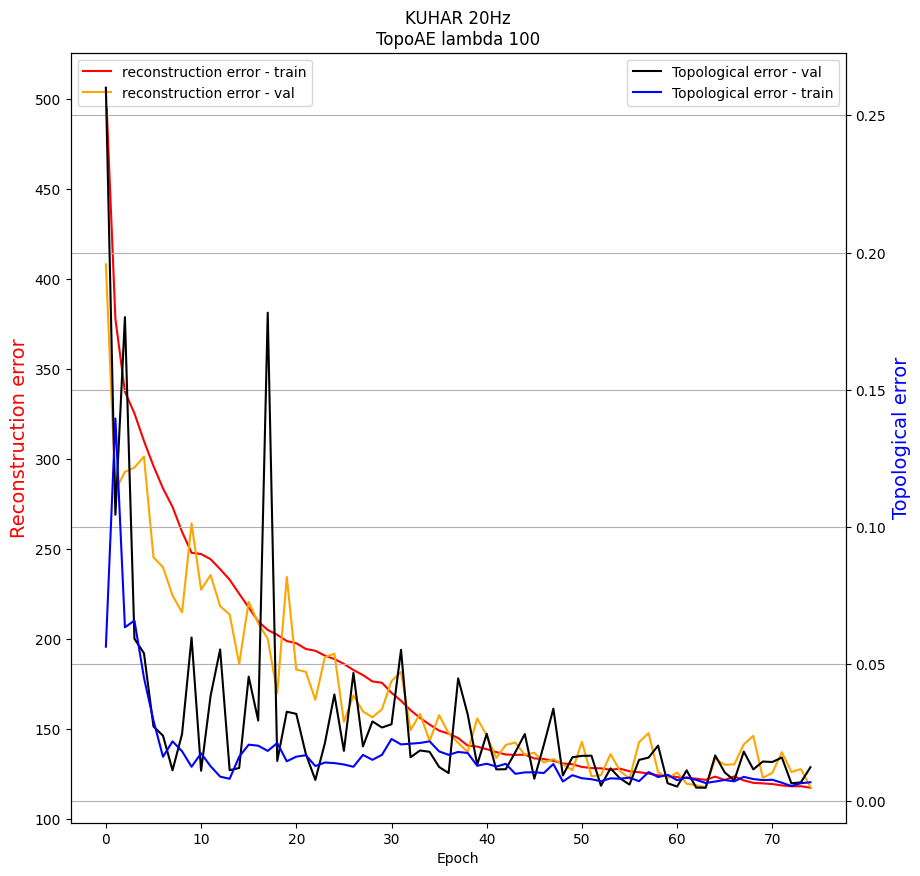

In [63]:
title_plot = "KUHAR 20Hz\nTopoAE lambda " + str(topoae_lambda)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [64]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [65]:
train_LD_pd = pd.DataFrame(train_LD)
train_LD_pd['y'] = train_Y
train_pmd = PandasMultiModalDataset(
    train_LD_pd,
    label_columns="y",
    as_array=True
)

test_LD_pd = pd.DataFrame(test_LD)
test_LD_pd['y'] = test_Y

test_pmd = PandasMultiModalDataset(
    test_LD_pd,
    label_columns="y",
    as_array=True
)

## Experiment for Random Forest

In [66]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [67]:
result = multi_run_experiment(train_pmd, test_pmd)

In [68]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.49576719576719575
F1 0.5102333351409667


In [69]:
table_info['Topo-AEv2 (L=100)'][0] = accuracy
table_info['Topo-AEv2 (L=100)'][1] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.484921 │          0.439418 │ 0.49576719576719575 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.494675 │          0.451774 │ 0.5102333351409667  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.325397 │          0.396825 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.380626 │          0.440117 │ -                   │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.473545 │          0

## Experiment for SVC

In [70]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [71]:
result = multi_run_experiment(train_pmd, test_pmd)

In [72]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.4656084656084656
F1 0.5008920377321816


In [73]:
table_info['Topo-AEv2 (L=100)'][2] = accuracy
table_info['Topo-AEv2 (L=100)'][3] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.484921 │          0.439418 │ 0.49576719576719575 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.494675 │          0.451774 │ 0.5102333351409667  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.325397 │          0.396825 │ 0.4656084656084656  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.380626 │          0.440117 │ 0.5008920377321816  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.473545 │          0

## Experiment for KNN

In [74]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [75]:
result = multi_run_experiment(train_pmd, test_pmd)

In [76]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.47619047619047616
F1 0.48465460000958344


In [77]:
table_info['Topo-AEv2 (L=100)'][4] = accuracy
table_info['Topo-AEv2 (L=100)'][5] = f1
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │ Topo-AEv2 (L=100)   │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.484921 │          0.439418 │ 0.49576719576719575 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.494675 │          0.451774 │ 0.5102333351409667  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.325397 │          0.396825 │ 0.4656084656084656  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.380626 │          0.440117 │ 0.5008920377321816  │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.473545 │          0

## Obtain quality metrics

In [78]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [79]:
metrics_report

{'residual variance (pearson)': 0.5749895782711794,
 'residual variance (spearman)': 0.6711994784247726,
 'trustworthiness': 0.905406621747724,
 'continuity': 0.9524061882333924,
 'co k nearest neighbor size': 0.4328580901856764,
 'local continuity meta criterion': 0.3903048986963147,
 'local property': 0.4678774787205358,
 'global property': 0.8129440852073392}

In [80]:
table_info['Topo-AEv2 (L=100)'][6] = metrics_report['trustworthiness']
table_info['Topo-AEv2 (L=100)'][7] = metrics_report['continuity']
table_info['Topo-AEv2 (L=100)'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP   │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ -      │     0.484921 │          0.439418 │            0.495767 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ -      │     0.494675 │          0.451774 │            0.510233 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -      │     0.325397 │          0.396825 │            0.465608 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -      │     0.380626 │          0.440117 │            0.500892 │
├─────────────────┼────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ -      │     0.473545 │          0

## Visualization

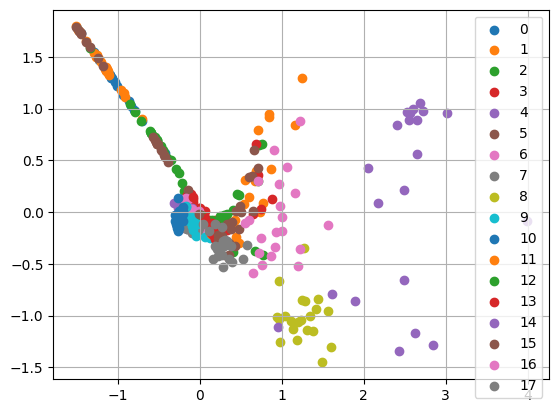

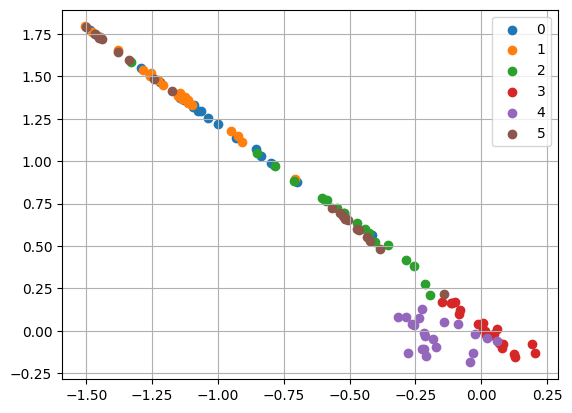

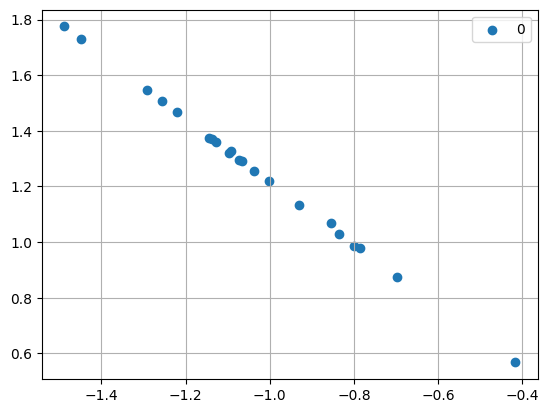

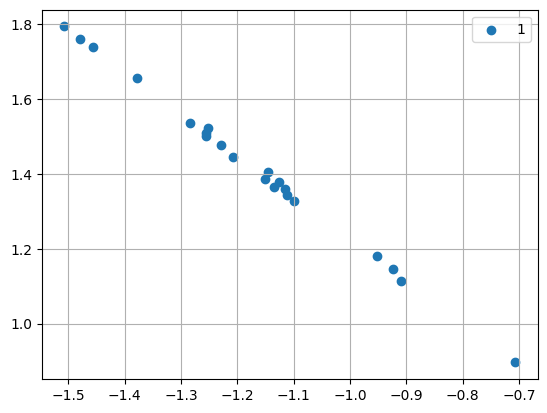

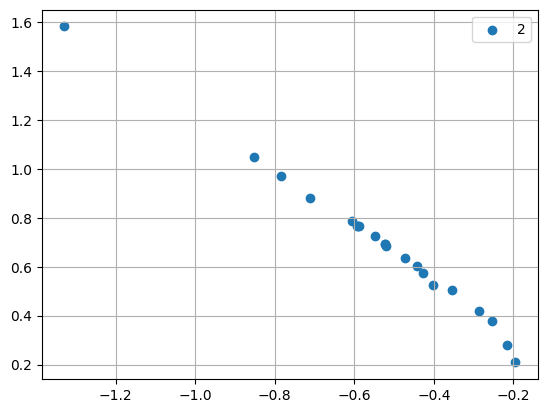

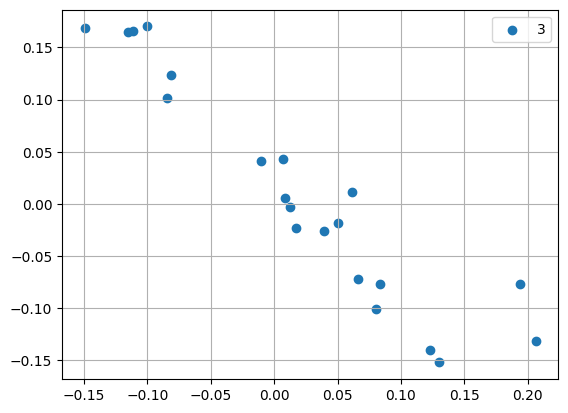

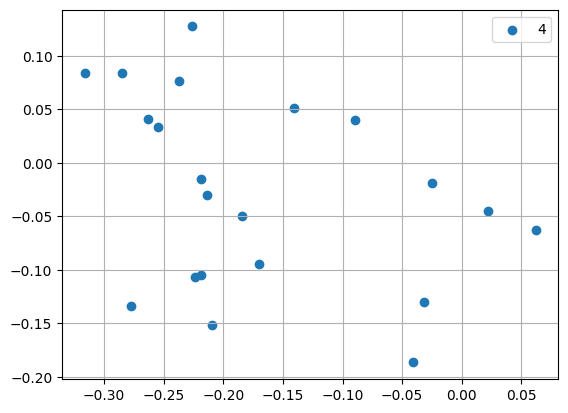

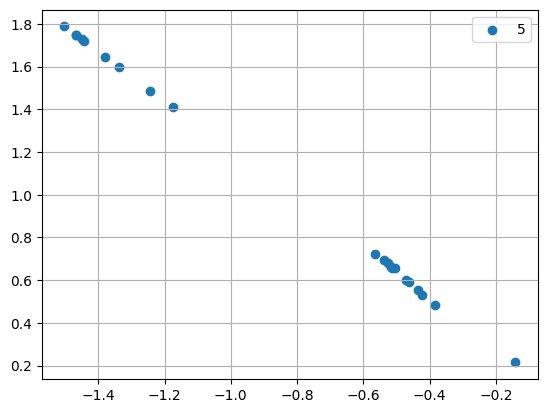

In [81]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run

# **SECTION:** UMAP

In [82]:
umap_reducer = UMAP()
umap_reducer.fit(train_HD, train_Y)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [83]:
train_LD = np.reshape(umap_reducer.transform(train_HD), (-1,2))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(umap_reducer.transform(test_HD), (-1,2))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3330, 2)
TEST LD RESHAPED (378, 2)


In [84]:
train_LD_pd = pd.DataFrame(train_LD)
train_LD_pd['y'] = train_Y
train_pmd = PandasMultiModalDataset(
    train_LD_pd,
    label_columns="y",
    as_array=True
)

test_LD_pd = pd.DataFrame(test_LD)
test_LD_pd['y'] = test_Y

test_pmd = PandasMultiModalDataset(
    test_LD_pd,
    label_columns="y",
    as_array=True
)

## Experiment for Random Forest

In [85]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    estimator_creation_kwags ={'n_estimators':100} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [86]:
result = multi_run_experiment(train_pmd, test_pmd)

In [87]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.8148148148148147
F1 0.8243867407161941


In [88]:
table_info['UMAP'][0] = accuracy
table_info['UMAP'][1] = f1
print_table(table_info)

╒═════════════════╤════════════════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP               │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪════════════════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ 0.8148148148148147 │     0.484921 │          0.439418 │            0.495767 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ 0.8243867407161941 │     0.494675 │          0.451774 │            0.510233 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ -                  │     0.325397 │          0.396825 │            0.465608 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ -                  │     0.380626 │          0.440117 │            0.500892 │
├─────────────────┼─

## Experiment for SVC

In [89]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC, 
    estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} ,
    do_not_instantiate=False, 
    do_fit=True,
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [90]:
result = multi_run_experiment(train_pmd, test_pmd)

In [91]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.828042328042328
F1 0.8347371239875231


In [92]:
table_info['UMAP'][2] = accuracy
table_info['UMAP'][3] = f1
print_table(table_info)

╒═════════════════╤════════════════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP               │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪════════════════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ 0.8148148148148147 │     0.484921 │          0.439418 │            0.495767 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ 0.8243867407161941 │     0.494675 │          0.451774 │            0.510233 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ 0.828042328042328  │     0.325397 │          0.396825 │            0.465608 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ 0.8347371239875231 │     0.380626 │          0.440117 │            0.500892 │
├─────────────────┼─

## Experiment for KNN

In [93]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    estimator_creation_kwags ={'n_neighbors' :1} ,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

In [94]:
result = multi_run_experiment(train_pmd, test_pmd)

In [95]:
accuracy = np.mean([run['result'][0]['accuracy'] for run in result['runs']])
f1 = np.mean([run['result'][0]['f1 score (weighted)'] for run in result['runs']])
print('ACCURACY', accuracy)
print('F1', f1)

ACCURACY 0.8042328042328042
F1 0.8126179939229645


In [96]:
table_info['UMAP'][4] = accuracy
table_info['UMAP'][5] = f1
print_table(table_info)

╒═════════════════╤════════════════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │ UMAP               │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪════════════════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ 0.8148148148148147 │     0.484921 │          0.439418 │            0.495767 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ 0.8243867407161941 │     0.494675 │          0.451774 │            0.510233 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ 0.828042328042328  │     0.325397 │          0.396825 │            0.465608 │
├─────────────────┼────────────────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ 0.8347371239875231 │     0.380626 │          0.440117 │            0.500892 │
├─────────────────┼─

## Obtain quality metrics

In [97]:
metrics_reporter = DimensionalityReductionQualityReport()
metrics_report = metrics_reporter.evaluate([test_HD, test_LD])

In [98]:
metrics_report

{'residual variance (pearson)': 0.8709850881611947,
 'residual variance (spearman)': 0.8084486017328519,
 'trustworthiness': 0.8822650389060743,
 'continuity': 0.8775060251144404,
 'co k nearest neighbor size': 0.46021220159151194,
 'local continuity meta criterion': 0.41765901010215023,
 'local property': 0.3844936002694623,
 'global property': 0.6806562845169586}

In [99]:
table_info['UMAP'][6] = metrics_report['trustworthiness']
table_info['UMAP'][7] = metrics_report['continuity']
table_info['UMAP'][8] = metrics_report['co k nearest neighbor size']
print_table(table_info)

╒═════════════════╤══════════╤══════════════╤═══════════════════╤═════════════════════╕
│ Metrics         │     UMAP │   Generic-AE │   Topo-AEv2 (L=1) │   Topo-AEv2 (L=100) │
╞═════════════════╪══════════╪══════════════╪═══════════════════╪═════════════════════╡
│ RF-ACC          │ 0.814815 │     0.484921 │          0.439418 │            0.495767 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┤
│ RF-F1           │ 0.824387 │     0.494675 │          0.451774 │            0.510233 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-ACC         │ 0.828042 │     0.325397 │          0.396825 │            0.465608 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┤
│ SVC-F1          │ 0.834737 │     0.380626 │          0.440117 │            0.500892 │
├─────────────────┼──────────┼──────────────┼───────────────────┼─────────────────────┤
│ KNN-ACC         │ 0.804233 │  

## Visualization

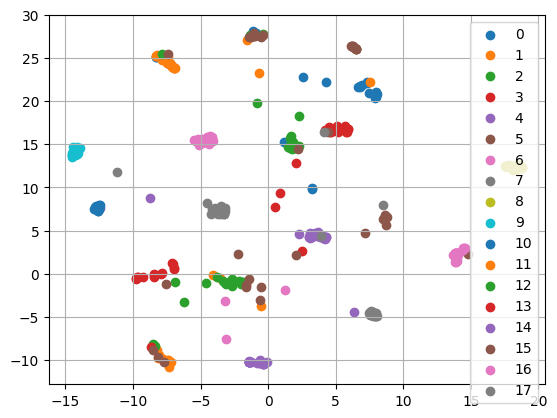

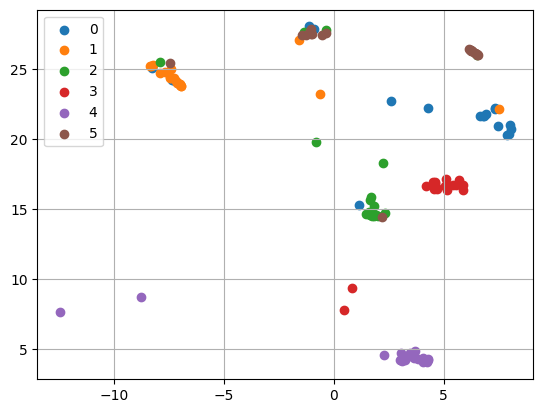

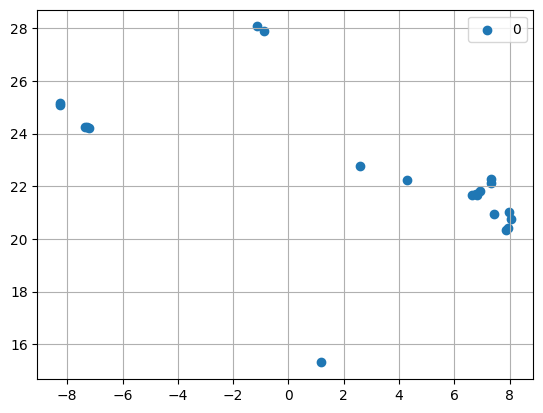

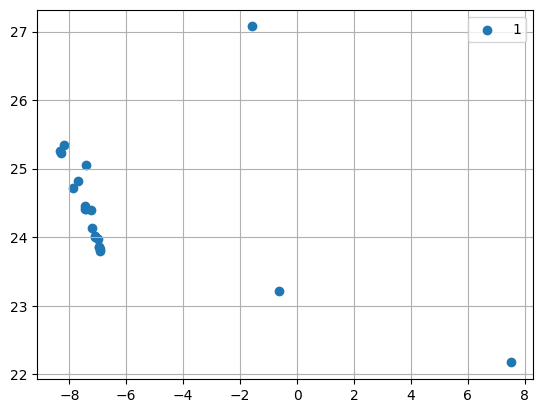

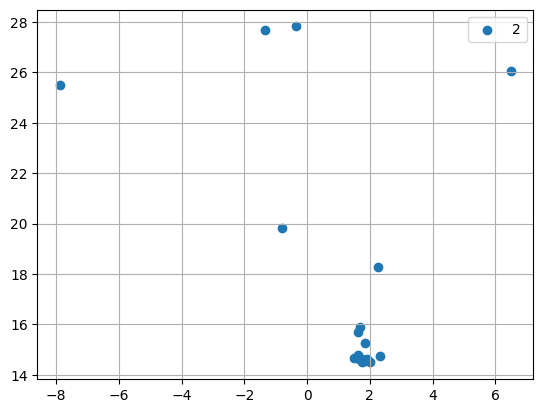

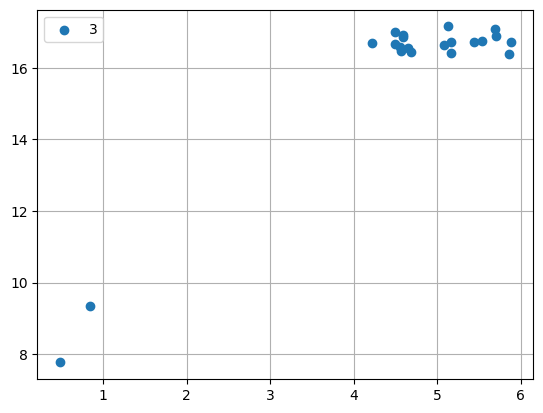

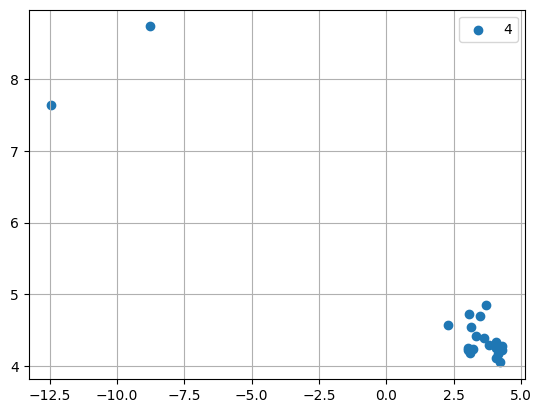

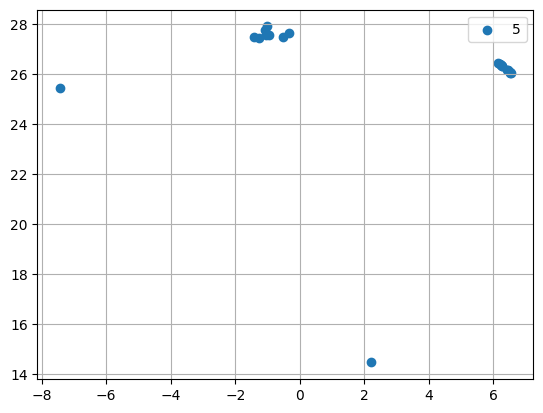

In [100]:
filter_to_use = [0,1,2,3,4,5]
visualize(test_LD, test_Y)
# visualize(test_LD, test_Y, filtered=filter_to_use, xlim=(-1,0), ylim=(-0.5,1.75))
visualize(test_LD, test_Y, filtered=filter_to_use)
for f in filter_to_use:
    # visualize(test_LD, test_Y, filtered=[f], xlim=(-1,0), ylim=(-0.5,1.75))
    visualize(test_LD, test_Y, filtered=[f])
# 0 sit
# 1 stand
# 2 walk
# 3 stair up
# 4 stair down
# 5 run